# Using logistic regression to generate a simple benchmark for future models.
If I know whether or not a user bought organic food before, how good is that at predicting whether or not they will buy organic in their next order?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [26]:
# Bring in modeling data
df = pd.read_csv('modeling_dfs/users_order_by_prev_org.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)

df_recs = pd.read_csv('top20_products_recom.csv')
print(df_recs['user_id'].unique())
df = df.loc[df_recs['user_id'].unique()]

display(df.head(5))
display(len(df))

[    1     2     5 ... 78704 78705 78707]


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,organic,organic_produce,any_organic,any_organic_produce,organic_non_produce,any_organic_non_produce,organic_prev,organic_produce_prev,any_organic_prev,any_organic_produce_prev
1,1492625,2,train,15,1,11,30.0,2.015,2.014,839880.0,6.0,1.0,True,True,5.0,True,4,3,True,True
2,2196797,5,train,5,0,11,6.0,5.005,5.004,157374.0,5.0,3.0,True,True,2.0,True,6,3,True,True
5,1094988,9,train,4,6,10,30.0,9.004,9.003,1830137.0,6.0,1.0,True,True,5.0,True,9,2,True,True
7,1827621,13,train,13,0,21,8.0,13.013,13.012,1789302.0,1.0,0.0,True,False,1.0,True,0,0,False,False
8,2316178,14,train,14,2,19,11.0,14.014,14.013,3394109.0,0.0,0.0,False,False,0.0,False,0,0,False,False


50000

## Build very simple model with no hyper-parameter tuning

In [27]:
# train the classifier on 80% of the data

y_col = 'any_organic_produce'
feature_cols = ['any_organic_produce_prev']
print('Features:')
print(feature_cols)

X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols], df[y_col], test_size=0.20, random_state=22)

logisticRegr = LogisticRegression(penalty='l1',solver='liblinear')
logisticRegr.fit(X_train,y_train)

Features:
['any_organic_produce_prev']


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Predicted organic purchases versus actual organic purchases

In [28]:
predictions = logisticRegr.predict(df[feature_cols])
df['predicted_'+y_col] = predictions
# display(df[['predicted_'+y_col,y_col]])

print('predicted distribution:')
display(df['predicted_'+y_col].value_counts())
display(df['predicted_'+y_col].value_counts(normalize=True))
print('actual distribution:')
display(df[y_col].value_counts())
display(df[y_col].value_counts(normalize=True))

predicted distribution:


True     27206
False    22794
Name: predicted_any_organic_produce, dtype: int64

True     0.54412
False    0.45588
Name: predicted_any_organic_produce, dtype: float64

actual distribution:


True     27399
False    22601
Name: any_organic_produce, dtype: int64

True     0.54798
False    0.45202
Name: any_organic_produce, dtype: float64

training data:
Mean accuracy:
0.7477
F1 score:
0.7685745734727573
ROC AUC score:
0.7458314929328622
Confusion matrix:
[[13150  4962]
 [ 5130 16758]]
ROC curve


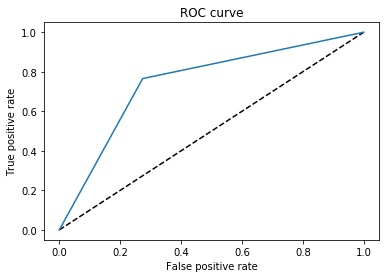

test data:
Mean accuracy:
0.7555
F1 score:
0.7776666363553696
ROC AUC score:
0.7531774782519449
Confusion matrix:
[[3279 1210]
 [1235 4276]]
ROC curve


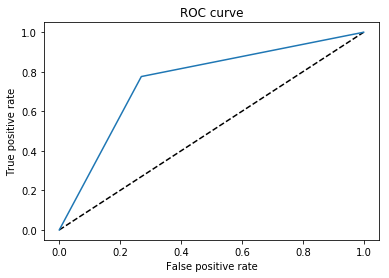

In [29]:
# Validation of model using built-in methods
def print_scores(X,y,model):
    print('Mean accuracy:')
    print(model.score(X,y))
    print('F1 score:')
    print(metrics.f1_score(y.astype(int),model.predict(X).astype(int)))
    print('ROC AUC score:')
    print(metrics.roc_auc_score(y.astype(int),model.predict(X).astype(int)))
    print('Confusion matrix:')
    print(metrics.confusion_matrix(y, model.predict(X)))
    
    print('ROC curve')
    fpr, tpr, _ = metrics.roc_curve(y.astype(int),model.predict(X).astype(int))
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()
    
print('training data:')
print_scores(X_train,y_train,logisticRegr)

print('test data:')
print_scores(X_test,y_test,logisticRegr)

#                       Predicted not-y,0   Predicted y,1
# True not-y,0
# True y,1